In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import os
import json
from copy import deepcopy as copy
import glob

/home/devuser/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import FRIB_model as frib

FRIB_model version: 1.0.0. updated on 2024-03-05


In [3]:
ISAAC_database_path = '/home/devuser/Desktop/WinHome/Workspace/BPM4pickup/ISAAC_data' 
ISAAC_data_rel_path = '20240118_103337_maruta_BDS_BTS_PM_D5567_pv_scan'

fm_evals, fm_goals, fm = frib.ish.get_flame_evals_n_goals_from_reconst_summary(
    ISAAC_data_rel_path = ISAAC_data_rel_path,
    ISAAC_database_path = ISAAC_database_path,
    return_flame = True)

# ISAAC reconstructed envelope 

In [4]:
r0,s0 = fm.run(monitor='all')
r0 = fm.collect_data(r0,'pos','xrms','yrms','cxy')

# New Fit at QV_D5501

In [5]:
from_element = 'BDS_BTS:QV_D5501'
to_element   = 'BDS_BTS:PM_D5567'
i_from_element = fm.get_index_by_name(from_element)[from_element][0]
i_to_element   = fm.get_index_by_name(to_element  )[to_element  ][0]
_, from_bmstate = fm.run(to_element=i_from_element-1)
from_moment1 = from_bmstate.moment1.copy()

In [6]:
r1,s1 = fm.run(bmstate=from_bmstate, monitor='all',from_element=i_from_element,to_element=to_element)
r1 = fm.collect_data(r1,'pos','xrms','yrms','cxy')

##### before fit

In [7]:
bmstate = from_bmstate
xalpha, xbeta, _ = copy(bmstate.get_twiss('x'))
yalpha, ybeta, _ = copy(bmstate.get_twiss('y'))
xnemit = copy(bmstate.xnemittance)
ynemit = copy(bmstate.ynemittance)
cxy, cxyp, cxpy, cxpyp = copy([bmstate.couple_xy, bmstate.couple_xyp, bmstate.couple_xpy, bmstate.couple_xpyp])
print(xalpha, xbeta, xnemit)
print(yalpha, ybeta, ynemit)
print(cxy, cxyp, cxpy, cxpyp)

-1.3477301185602333 7.14345122021582 0.154490012057611
-0.8503027690094562 3.6873702585608132 0.15983893165812538
0.2624341481173254 0.7262878727981832 0.7053216000073145 0.6747359242119026


##### fitting

1-th trial, current_loss: 0.00162, best_loss: 0.00162


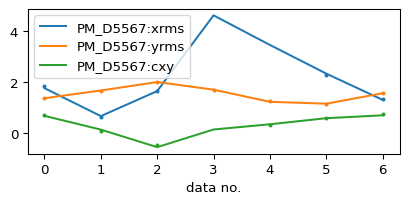

In [8]:
frib.fmh.fit_moment1(fm,fm_evals,fm_goals,
                     from_bmstate = from_bmstate,
                     from_element= i_from_element-1,
                     to_element  = i_to_element,
                     n_try = 20,
                     stop_criteria = 0.002,
                     start_fit_from_current_bmstate = True,
                     plot_fitting_quality = True,
                    )

##### after fit

In [9]:
bmstate = from_bmstate
xalpha, xbeta, _ = copy(bmstate.get_twiss('x'))
yalpha, ybeta, _ = copy(bmstate.get_twiss('y'))
xnemit = copy(bmstate.xnemittance)
ynemit = copy(bmstate.ynemittance)
cxy, cxyp, cxpy, cxpyp = copy([bmstate.couple_xy, bmstate.couple_xyp, bmstate.couple_xpy, bmstate.couple_xpyp])
print(xalpha, xbeta, xnemit)
print(yalpha, ybeta, ynemit)
print(cxy, cxyp, cxpy, cxpyp)

-1.3925136763009427 7.093238369929288 0.15012603996278914
-0.8396852044590839 3.652570070811225 0.16015380630969928
0.07638673104911992 0.7824947498030224 0.9999999990868458 0.6849848514034684


In [10]:
r2,s2 = fm.run(bmstate=from_bmstate, monitor='all',from_element=i_from_element,to_element=to_element)
r2 = fm.collect_data(r2,'pos','xrms','yrms','cxy')

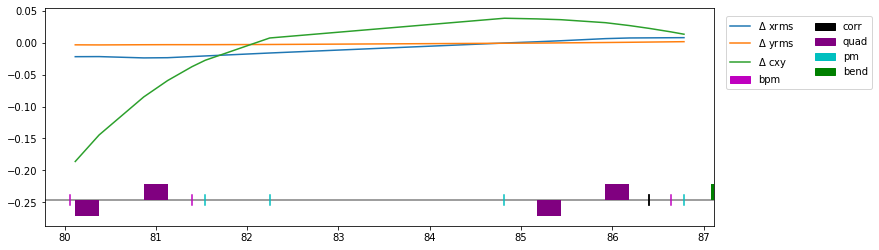

In [11]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(r2['pos'],r2['xrms']-r1['xrms'],label=r'$\Delta$ xrms')
ax.plot(r2['pos'],r2['yrms']-r1['yrms'],label=r'$\Delta$ yrms')
ax.plot(r2['pos'],r2['cxy' ]-r1['cxy' ],label=r'$\Delta$ cxy')
frib.fmh.plot_lattice(fm,ax)

# flame_results

In [12]:
frib.fmh.calculate_loss_from_flame_evals_goals(fm_evals,fm_goals,fm,from_bmstate,
                                                from_element=from_element,
                                                to_element=to_element,
                                               )

0.0017005081964457027

In [13]:
flame_results = frib.fmh.evaluate_flame_evals(
    fm_evals,fm,from_bmstate,
    from_element=from_element,
    to_element=to_element,
    monitor_names = list(fm_goals['info'].keys()),
    )

In [14]:
flame_results

BDS_BTS:PM_D5567                    
              xrms      yrms       cxy
0         1.760505  1.373967  0.677791
1         0.673728  1.672282  0.146951
2         1.633614  1.999944 -0.544523
3         4.589166  1.705473  0.167732
4         3.438703  1.239547  0.366165
5         2.324208  1.167078  0.589507
6         1.306161  1.564951  0.698200

Text(0.5, 0, 'data no.')

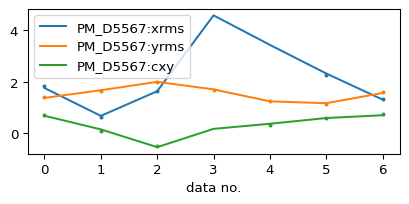

In [15]:
flame_goals = fm_goals

monitors = list(flame_goals['info'].keys())
for i,m in enumerate(monitors):
    fig,ax = plt.subplots(figsize=(5,2), dpi=96)
    for k in flame_results[m].columns:
        col = (m,k)
        if not np.all(np.isnan(flame_goals['df'][col])):
            x = np.arange(len(flame_results))
            ax.scatter(x,flame_goals['df'][col],s=4)
            ax.plot   (x,flame_results[col],label=m[m.find(":")+1:]+':'+k)
    ax.legend()
ax.set_xlabel('data no.')